In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from dataclasses import dataclass
from multiprocessing import Process, Queue
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error

In [14]:
# Parameters for Lorenz system near bifurcation point (rho=1)
rho=1.1
sigma = 10
beta = 8/3

# Parameters for normal form (G+H, '83)
mu = rho - 1
omega = np.sqrt(sigma)
alpha = (sigma + 1)/(2*sigma)
b = 1/2

# Normal form of Lorenz system near bifurcation point (G+H '83)
def lorenz_normal(t, xyz, mu=mu, omega=omega, alpha=alpha, b=b, beta=beta):
   x, y, z = xyz
   dxdt = mu*x - omega*y + alpha*x*z
   dydt = omega*x + mu*y + alpha*y*z
   dzdt = -2*beta*z + b*(x**2 + y**2)
   return [dxdt, dydt, dzdt]

Text(0.5, 0, 'z')

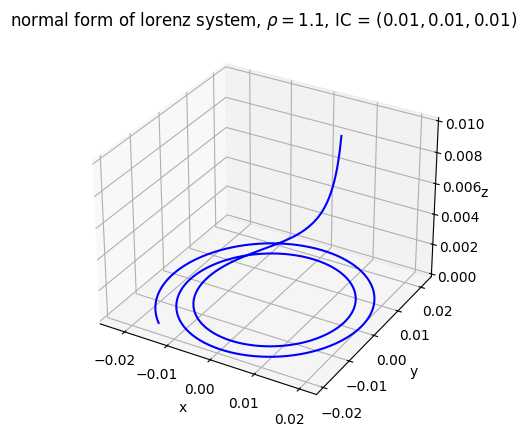

In [73]:
# Simulate the actual system
t_span = (0, 5)
dt = 0.01
initial_condition = [0.01, 0.01, 0.01]

t_eval = np.arange(t_span[0], t_span[1], dt)
actual_solution = solve_ivp(lorenz_normal, t_span, initial_condition, t_eval = t_eval)
x_actual = actual_solution.y.T

# plot normal form
fig = plt.figure(figsize=(11, 5))
ax0 = fig.add_subplot(111, projection = '3d')
ax0.plot(*x_actual.T, color = 'blue', label = 'actual')
ax0.set_title(rf"normal form of lorenz system, $\rho={rho}$, " +
              rf"IC = $({initial_condition[0]}, {initial_condition[1]}, {initial_condition[2]})$")
ax0.set_xlabel("x"); ax0.set_ylabel("y"); ax0.set_zlabel("z", labelpad=1)



In [74]:
# Add noise. Specify the seed for reproducible results.
rng = np.random.default_rng(seed=65)
noise_strength = 0.01
x_noisy = x_actual + noise_strength * rng.standard_normal(x_actual.shape)

(x0)' = -0.268 x0 + -2.112 x1 + 2.500 x2 + 395.304 x0 x2
(x1)' = 3.364 x0 + 3.202 x2 + -377.420 x0 x2
(x2)' = -0.636 x0 + -1.663 x1 + -1.610 x2


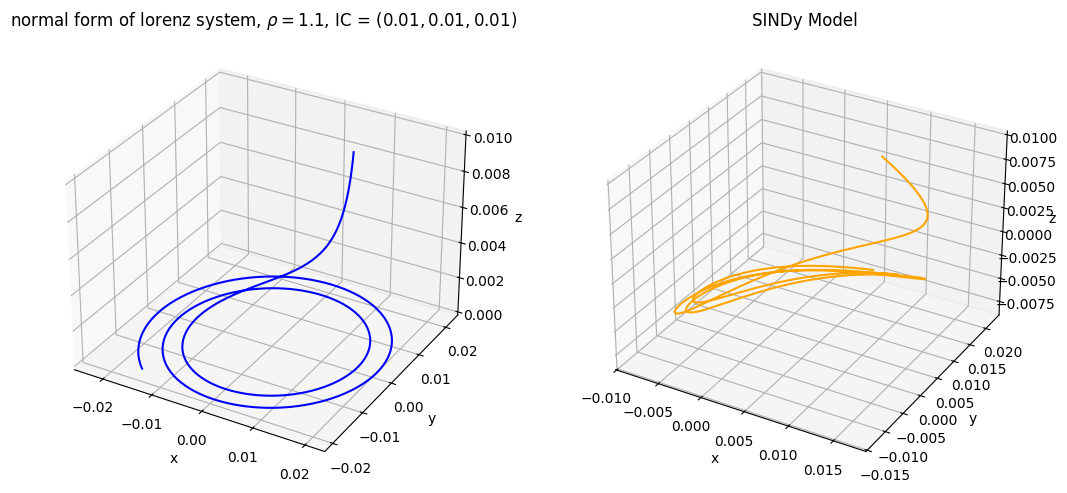

In [75]:
# Fit SINDy model
model = ps.SINDy()
model.fit(x_noisy, t = dt)
model.print()

# Simulate SINDy model
x_sindy = model.simulate(initial_condition, t_eval)

# plot comparison of actual system vs sindy model
fig = plt.figure(figsize=(11, 5))
ax0 = fig.add_subplot(121, projection = '3d')
ax0.plot(*x_actual.T, color = 'blue', label = 'actual')
ax0.set_title(rf"normal form of lorenz system, $\rho={rho}$, " +
              rf"IC = $({initial_condition[0]}, {initial_condition[1]}, {initial_condition[2]})$")
ax0.set_xlabel("x"); ax0.set_ylabel("y"); ax0.set_zlabel("z")

ax1 = fig.add_subplot(122, projection='3d')
ax1.plot(*x_sindy.T, color = 'orange', label = 'SINDy')
ax1.set_title("SINDy Model")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z", labelpad=1)

plt.tight_layout()
plt.show()

In [78]:
def compute_mse(real, simulated, print_mse=True):
   # Compute MSE per variable and total
   mse_x = mean_squared_error(real[:, 0], simulated[:, 0])
   mse_y = mean_squared_error(real[:, 1], simulated[:, 1])
   mse_z = mean_squared_error(real[:, 2], simulated[:, 2])
   mse_total = mean_squared_error(real, simulated)

   if print_mse:
      print("\nMean Squared Error (MSE) between normal form of Lorenz system and SINDy model:")
      print(f"  x: {mse_x:.4f}")
      print(f"  y: {mse_y:.4f}")
      print(f"  z: {mse_z:.4f}")
      print(f"  Total (all variables): {mse_total:.4f}")
   
   return mse_total

compute_mse(x_actual, x_sindy)


Mean Squared Error (MSE) between normal form of Lorenz system and SINDy model:
  x: 0.0002
  y: 0.0002
  z: 0.0000
  Total (all variables): 0.0001


0.0001388027990682602

In [97]:
# Repeat the above procedure in a loop with different noise profiles.
# Goal: minimize MSE
noise_strength = 0.02
num_iterations = 20

class SimResults:
   def __init__(self):
      self.mse = None
      self.x_sindy = None
      self.model = None


def run_simulation(noisy_signal, result_queue):
   model = ps.SINDy()
   model.fit(noisy_signal, t = dt)
   x_sindy = model.simulate(initial_condition, t_eval)
   result = SimResults()
   result.mse = compute_mse(x_actual, x_sindy, False)
   result.x_sindy = x_sindy
   result.model = model
   result_queue.put(result)

mse_to_result_map = {}
q = Queue()
rng = np.random.default_rng(seed=65)  # re-seed the rng for reproducibility

for i in range(0, num_iterations):
   x_noisy = x_actual + noise_strength * rng.standard_normal(x_actual.shape)

   # Run the SINDy simulation in a separate process.  If it doesn't converge
   # in 10 seconds, then kill it.
   p = Process(target=run_simulation, args=(x_noisy, q,))
   p.start()
   p.join(timeout=10)

   if p.is_alive():
      p.terminate()
      p.join()
   else:
      result = q.get()
      mse_to_result_map[result.mse] = result

minimized_mse = min(mse_to_result_map.keys())
maximized_mse = max(mse_to_result_map.keys())
print(f"Minimized MSE: {minimized_mse}")
print(f"Maximized MSE: {maximized_mse}")


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3238309538233D+01   r2 =  0.2163765954701D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3238309538233D+01   r2 =  0.2163765954701D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3238309538233D+01   r2 =  0.2163765954701D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3238309538233D+01   r2 =  0.2163765954701D-15
 lsoda--  warning..internal t (=r1) 

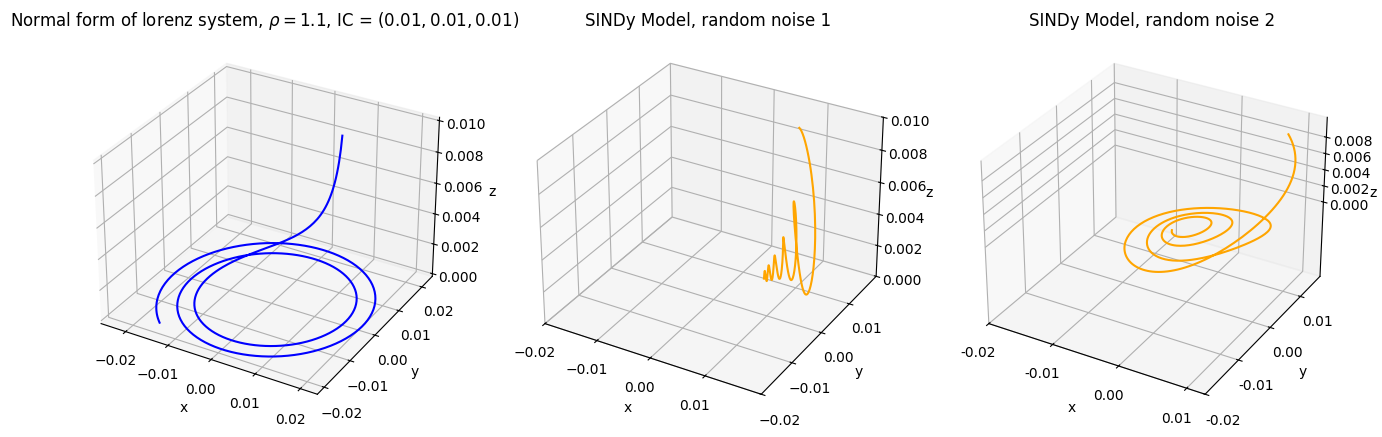

SINDy model corresponding to minimized MSE:
(x0)' = -1.043 x0 + -1.841 x1 + 3.100 x2 + -36.924 x0^2 + -94.975 x0 x1 + 302.757 x0 x2 + 20.337 x1^2 + -73.331 x2^2
(x1)' = 3.184 x0 + 3.213 x2 + -298.547 x0 x2 + -48.138 x1^2 + 41.247 x1 x2
(x2)' = -1.272 x0 + -3.071 x1 + -2.006 x2 + -22.221 x0^2 + 55.037 x0 x2 + -23.195 x1^2 + 81.849 x1 x2 + 75.308 x2^2


In [146]:
minimized_mse = min(mse_to_result_map.keys())
maximized_mse = max(mse_to_result_map.keys())

almost_maximized_mse = sorted(mse_to_result_map.keys())[-3]

# Finally, plot the results for the minimized MSE vs. the actual system
fig = plt.figure(figsize=(21, 5))
ax0 = fig.add_subplot(121, projection = '3d')
ax0.plot(*x_actual.T, color = 'blue', label = 'actual')
ax0.set_title(rf"Normal form of lorenz system, $\rho={rho}$, " +
              rf"IC = $({initial_condition[0]}, {initial_condition[1]}, {initial_condition[2]})$")
ax0.set_xlabel("x"); ax0.set_ylabel("y"); ax0.set_zlabel("z")

ax1 = fig.add_subplot(132, projection='3d')
ax1.plot(*mse_to_result_map[almost_maximized_mse].x_sindy.T, color = 'orange', label = 'SINDy')
ax1.set_title("SINDy Model, random noise 1")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z", labelpad=1)
ax1.set_xlim(-0.02, 0.02)
ax1.set_ylim(-0.02, 0.02)
ax1.set_zlim(0, 0.01)
ax1.set_xticks(np.arange(-.02, .02, .01))
ax1.set_yticks(np.arange(-.02, .02, .01))

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*mse_to_result_map[minimized_mse].x_sindy.T, color = 'orange', label = 'SINDy')
ax2.set_title("SINDy Model, random noise 2")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z", labelpad=1)
#ax2.set_zlim(0, 0.01)
ax2.set_xticks(np.arange(-.02, .02, .01))
ax2.set_yticks(np.arange(-.02, .02, .01))
ax2.set_zticks(np.arange(0, .01, .002))

from matplotlib.ticker import FormatStrFormatter
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.tight_layout()
plt.show()

print("SINDy model corresponding to minimized MSE:")
mse_to_result_map[minimized_mse].model.print()
fig.savefig('/home/evan/Downloads/lorenz-normal-form.pdf')